# Chebyshev fit to light curves

In [1]:
cd WFIRST_microlensing_feature_creator/

/Users/Research/Library/Mobile Documents/com~apple~CloudDocs/Research/WFIRST-event-finder/Filters/tests/WFIRST_microlensing_feature_creator


In [2]:
from Common_functions import localize_event, prepare

In [3]:
import glob,os,sys
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
from tqdm import tqdm
from numpy import *
import re
import scipy.stats as st
from os.path import expanduser
import matplotlib.cm as cm
import cmath
import scipy.optimize as op
import time
import gzip
import pandas as pd
import traceback
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition)
from sympy.solvers import solve
from sympy import Symbol
import sympy
from scipy.interpolate import interp1d
from numpy.polynomial.chebyshev import chebfit,Chebyshev, chebval
from Planetary_fit import Planetary_fit
from lc import lc
from Chebyshev_fit import Chebyshev_fit
%matplotlib inline

In [4]:
#Source = https://excamera.com/sphinx/article-chebyshev.html

import math

class Chebyshev:
    """
    Chebyshev(a, b, n, func)
    Given a function func, lower and upper limits of the interval [a,b],
    and maximum degree n, this class computes a Chebyshev approximation
    of the function.
    Method eval(x) yields the approximated function value.
    """
    def __init__(self, a, b, n, func):
        self.a = a
        self.b = b
        self.func = func

        bma = 0.5 * (b - a)
        bpa = 0.5 * (b + a)
        f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
        fac = 2.0 / n
        self.c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
                  for k in range(n)]) for j in range(n)]

    def eval(self, x):
        a,b = self.a, self.b
        assert(a <= x <= b)
        y = (2.0 * x - a - b) * (1.0 / (b - a))
        y2 = 2.0 * y
        (d, dd) = (self.c[-1], 0)             # Special case first step for efficiency
        for cj in self.c[-2:0:-1]:            # Clenshaw's recurrence
            (d, dd) = (y2 * d - dd + cj, d)
        return y * d - dd + 0.5 * self.c[0]
    
    

In [5]:

home = os.path.expanduser("~")

temp = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'#lc/'
direc = os.listdir(temp)

In [6]:
def calc_chisq(lightcurve,e,fx):
    """Function to calculate the chi squared of the fit of the lightcurve
    data to the function provided"""
    
    chisq = ((lightcurve - fx)**2 / (e**2)).sum()
    
    return chisq/(len(e)-50)

In [7]:
# Smoothing the data

def low_pass_filter(y, box_pts, mode='same', base=1):
    box = base*(np.ones(box_pts)/box_pts)
    y_filtered = np.convolve(y, box, mode=mode)
    if mode=='same':
        y_filtered[0:int(box_pts/2)]=y_filtered[int(box_pts/2)]
        y_filtered[len(y_filtered)-int(box_pts/2):len(y_filtered)]=y_filtered[len(y_filtered)-int(box_pts/2)]
    return y_filtered

In [8]:
def localize_event(lightcurve,t0,tE):
    """Function to estimate roughly the area around the peak of an event, 
    and identify which timestamps in the array belong to the event versus
    the baseline
    """
    
    idx1 = np.where(lightcurve >= t0-tE)[0]
    idx2 = np.where(lightcurve <= t0+tE)[0]
    event = list(set(idx1).intersection(set(idx2)))
    
    baseline = np.arange(0,len(lightcurve),1)
    baseline = np.delete(baseline,event)
    
    it0 = np.where(lightcurve == t0)[0][0]
    
    return baseline, event, it0

In [9]:
# @require('lc', 'Planetary_fit')
def Chebyshev_Fitter(f):
  chebfit = Chebyshev_fit(f)
  chebfit.Chebyhev_coefficients(50)
  chebfit.eval()
  chebfit.feature_producer()

  return chebfit

In [10]:
# Reading in one single lightcurve

f = '/magtrue.ombin_0_57_185.det.lc.W149' #non-binary

t,m,e = np.loadtxt(temp+f,unpack=True, usecols=(0,1,2))
peaks = np.array([t[np.argmin(m)]])

In [13]:
lc = lc(temp+f,delta_t=10)

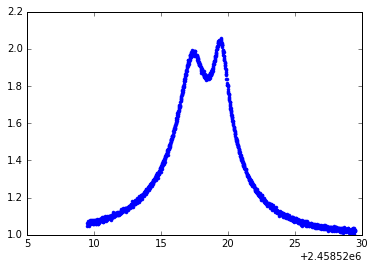

In [14]:
plt.plot(lc.df.t[lc.event], lc.df.A[lc.event], '.')

In [37]:
baseline, event, it0 = localize_event(df['t'], peaks[0],10)

In [11]:
Chebfit = Chebyshev_Fitter(temp+f)

Chebyshev_fit.py:72: RuntimeWarning: invalid value encountered in log10
  self.log10_Cheby_cj_sqr_odd_minus_one = np.log10(self.Cheby_cj_sqr_odd - 1)
Chebyshev_fit.py:75: RuntimeWarning: invalid value encountered in log10
  self.pos_log10_Cheby_cj_sqr_odd_minus_one = -1*np.log10(self.Cheby_cj_sqr_odd - 1)


In [36]:
df, interpol, event, it0, dt = prepare(t,m,e)

In [62]:
t_new = df['t'][event]#df['t'][(df['t']>peaks[0]-dt) & (df['t']<peaks[0]+dt)]
m_new = df['A'][event]

In [63]:
t_scaled = np.interp(t_new, (t_new.min(), t_new.max()), (-1, +1))
# m_scaled = np.interp(m_new, (m_new.min(), m_new.max()), (-1, +1))

In [64]:
res = chebfit(t_scaled,m_new,50)

In [65]:
res

array([ 1.22935435e+00, -6.99126327e-02, -2.98148721e-01,  1.03497626e-01,
        1.71181187e-01, -9.38984018e-02, -9.02891993e-02,  7.17235961e-02,
        4.33280425e-02, -4.58932566e-02, -1.84096413e-02,  2.43756025e-02,
        7.47927793e-03, -6.07502210e-03, -5.96962374e-03, -3.92714751e-03,
        7.65804784e-03,  1.07669062e-02, -1.21914597e-02, -1.17511467e-02,
        1.52875663e-02,  1.07324755e-02, -1.77317030e-02, -7.62538442e-03,
        1.78877923e-02,  4.73140643e-03, -1.73178324e-02, -1.24065554e-03,
        1.48101957e-02, -5.57570846e-04, -1.31800909e-02,  2.62141164e-03,
        9.92625273e-03, -2.32362028e-03, -7.96556427e-03,  3.49226580e-03,
        5.60527560e-03, -1.78435984e-03, -4.61442308e-03,  1.98681459e-03,
        2.74844801e-03, -1.09817003e-03, -3.59294769e-03,  6.84746428e-04,
        1.89738431e-03, -1.96100994e-04, -3.13645783e-03,  1.06715249e-04,
        1.53104844e-03, -2.82942084e-05, -2.91570922e-03])

In [39]:
interpol = interp1d(df['t'],df['A'], kind='cubic')

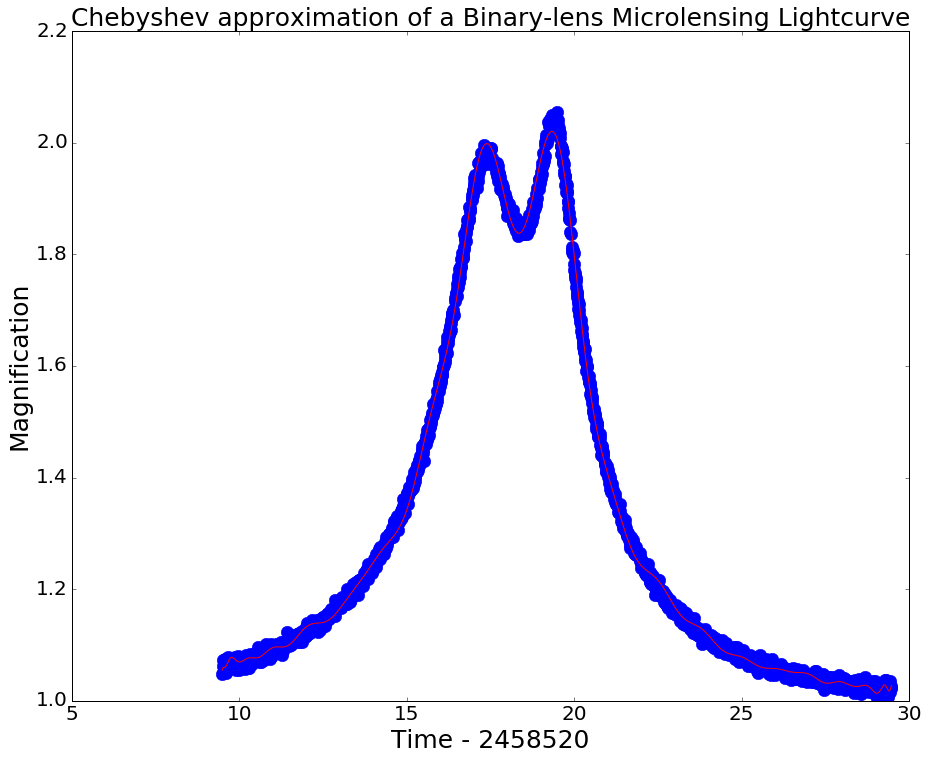

In [12]:
c = 2
plt.plot(Chebfit.df['t'][Chebfit.event]-2458520,Chebfit.df['A'][Chebfit.event],'b.', markersize=25, label='Lightcurve Data')
# plt.plot(np.sort(Chebfit.df['t'][event].values)-2458520,Chebfit.interpol_A(np.sort(Chebfit.df['t'][event].values)),'r-', Label='Chebyshev Approximation')
plt.plot(np.sort(Chebfit.df['t'][Chebfit.event].values)-2458520,Chebfit.Cheby_func,'r-', Label='Chebyshev Approximation')
# plt.plot(t_scaled,chebval(t_scaled,res)[0:],'r-', Label='Chebyshev Approximation')


plt.ylabel('Magnification', size=25)
plt.xlabel('Time - 2458520', size=25)
plt.title('Chebyshev approximation of a Binary-lens Microlensing Lightcurve',size=25)
# plt.xlim(Chebfit.df.t[Chebfit.t_idx]-2458520-c*Chebfit.tE, Chebfit.df.t[Chebfit.t_idx]-2458520+c*Chebfit.tE)
# plt.legend(loc=2,fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.axvline(Chebfit.t[Chebfit.t_idx])
fig = plt.gcf()
fig.set_size_inches(15.0,12.0)
# plt.savefig('Chebyshevfit_success.png')

In [147]:
# (np.abs((df['t'][event]-2458520).diff())).min()

In [40]:
ch = Chebyshev(min(df['t'][event]),max(df['t'][event]), 50, interpol)


In [41]:
min(df['t'][event].values)

2458529.489344

In [42]:
cheb = []
for i in np.sort(df['t'][event].values):
    cheb.append(ch.eval(i))
    

In [43]:
plfit = Planetary_fit(temp+f)
plfit.initial_guess_finder()

In [44]:
t0 = 0#plfit.t0_true-1.5

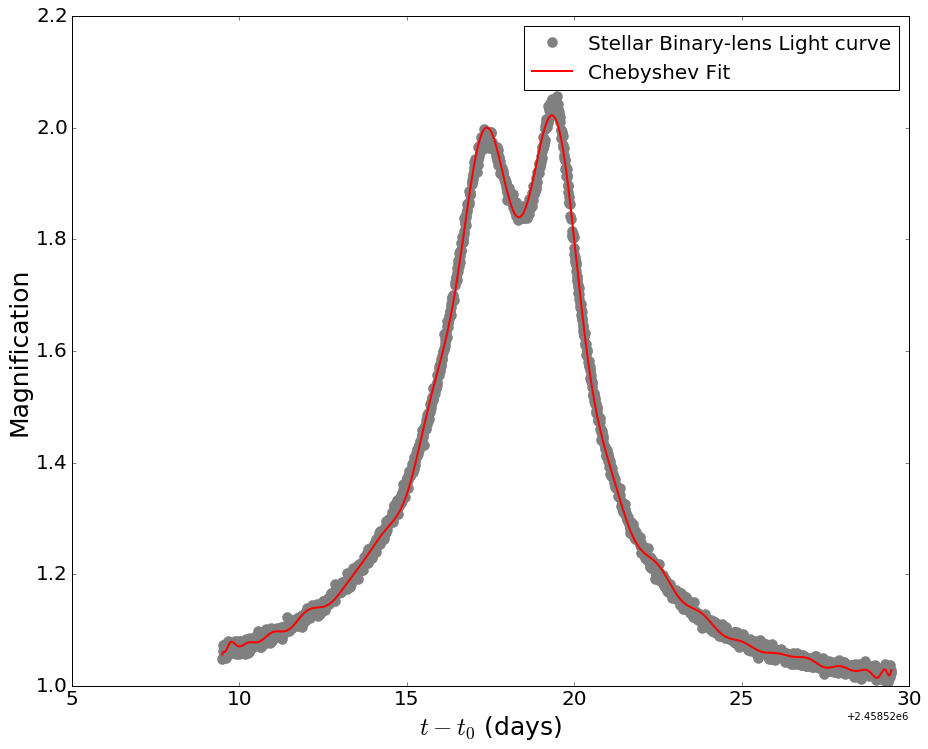

In [45]:
c = 1
plt.plot(df['t'][event]-t0,df['A'][event],'.',color='grey', markersize=20, label='Stellar Binary-lens Light curve')
# plt.plot(np.sort(df['t'][event].values)-t0,np.asarray(Chebfit.Cheby_func),'-',color='red', linewidth=2, label='Chebyshev Fit')
plt.plot(np.sort(df['t'][event].values)-t0,np.asarray(cheb),'-',color='red', linewidth=2, label='Chebyshev Fit')


plt.ylabel('Magnification', size=25)
plt.xlabel('$t-t_0$'+' (days)', size=25)
# plt.title('Chebyshev approximation of a Binary-lens Microlensing Lightcurve',size=25)
# plt.xlim(df.t[it0]-t0-c*dt+2, df.t[it0]-t0+c*dt)

plt.legend(loc=1,fontsize=20,numpoints=1)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


fig = plt.gcf()
fig.set_size_inches(15.0,12.0)
# plt.savefig('./../test_result/Chebyshev/Chebyshevfit_success_n500.png')



In [158]:
Chebfit.log10_Cheby_cj_sqr_minus_one

-1.7400481930299565

In [13]:
#Trying it on Data Challenge light curves


direc.sort()
result = {'name':[], 'c_j':[], 'chi_2':[], 'chebfunc':[],\
          'c_j2':[],'c_j2_even':[],'c_j2_odd':[], 'a0':[], 'a2':[]\
         , 'a4':[], 'a6':[], 'a8':[], 'a10':[], 'log_c_j2_minus_one':[],\
         'log_c_j2_even_minus_one': [], 'log_c_j2_odd_minus_one': []}
c = 0 

for f in tqdm(direc):
    #print f
    
    if  f.endswith('.W149'): #f.endswith('.txt') and f.split('_')[2].startswith('W'):
        
#         print c
#         c = c +1
        
        try:
            Chebfit = Chebyshev_Fitter(temp+f)
            chi_2 = calc_chisq(Chebfit.df['A'][Chebfit.event],Chebfit.df['A_err'][Chebfit.event], Chebfit.Cheby_func )

            result['name'].append(f)
            result['c_j'].append(Chebfit.Chebyhev_coefficients)
            result['chi_2'].append(chi_2)
            result['chebfunc'].append(Chebfit.Cheby_func)
            result['c_j2'].append(Chebfit.Cheby_cj_sqr)
            result['c_j2_even'].append(Chebfit.Cheby_cj_sqr_even)
            result['c_j2_odd'].append(Chebfit.Cheby_cj_sqr_odd)
            result['log_c_j2_minus_one'].append(Chebfit.log10_Cheby_cj_sqr_minus_one)
            result['log_c_j2_even_minus_one'].append(Chebfit.log10_Cheby_cj_sqr_even_minus_one)
            result['log_c_j2_odd_minus_one'].append(Chebfit.log10_Cheby_cj_sqr_odd_minus_one)
            result['a0'].append(Chebfit.Cheby_a0)
            result['a2'].append(Chebfit.Cheby_a2)
            result['a4'].append(Chebfit.Cheby_a4)
            result['a6'].append(Chebfit.Cheby_a6)
            result['a8'].append(Chebfit.Cheby_a8)
            result['a10'].append(Chebfit.Cheby_a10)

            
        except (RuntimeError, TypeError, NameError, ValueError, RuntimeWarning):
            traceback.print_exc()
            print f
            pass

print 'done'






 62%|██████▏   | 6154/9948 [20:45<12:47,  4.94it/s]Chebyshev_fit.py:71: RuntimeWarning: divide by zero encountered in log10
  self.log10_Cheby_cj_sqr_even_minus_one = np.log10(self.Cheby_cj_sqr_even - 1)
Chebyshev_fit.py:74: RuntimeWarning: divide by zero encountered in log10
  self.pos_log10_Cheby_cj_sqr_even_minus_one = -1*np.log10(self.Cheby_cj_sqr_even - 1)
100%|██████████| 9948/9948 [33:35<00:00,  4.94it/s]

done


In [14]:
info1 = pd.read_csv('./../answer_keys/ombin.CSV')
info2 = pd.read_csv('./../answer_keys/omcassan.CSV')
info3 = pd.read_csv('./../answer_keys/dccv.CSV')
info4 = pd.read_csv('./../answer_keys/dcnormffp.CSV')

In [15]:
frames = [info1, info2, info3, info4]

info = pd.concat(frames)

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [206]:
# c_j2 = (np.sum(np.asarray(result['c_j'][j])**2) for j in range(len(result['c_j'])))

In [207]:
# c_j2 = []
# for j in range(len(result['c_j'])):
    
#     c_j2.append(np.sum(np.asarray(result['c_j'][j]/result['c_j'][j][0])**2))
               

In [16]:
true_type = []

for i in (result['name']):
    
    if i.split('.')[1].split('_')[0]=='dccv':
        true_type.append(0)
    elif i.split('.')[1].split('_')[0]=='dcnormffp':
        true_type.append(3)
    elif i.split('.')[1].split('_')[0]=='omcassan':
        true_type.append(2)
    elif i.split('.')[1].split('_')[0]=='ombin':
        true_type.append(1)
        

In [17]:
info['c_j2'] = np.zeros(len(info))
info['c_j2_even'] = np.zeros(len(info))
info['c_j2_odd'] = np.zeros(len(info))
info['log_c_j2'] = np.zeros(len(info))
info['log_c_j2_even'] = np.zeros(len(info))
info['log_c_j2_odd'] = np.zeros(len(info))
info['chi_2'] = np.zeros(len(info))
info['type'] = np.zeros(len(info))
info['a0'] = np.zeros(len(info))
info['a2'] = np.zeros(len(info))
info['a4'] = np.zeros(len(info))
info['a6'] = np.zeros(len(info))
info['a8'] = np.zeros(len(info))
info['a10'] = np.zeros(len(info))


In [18]:
# info = info.rename(columns={"index": "name"})

In [19]:
for i in range(len(result['name'])):

    if result['name'][i].split('.lc')[0].endswith('all'): 
        result['name'][i] = result['name'][i].split('all')[0]+'det'+result['name'][i].split('all')[1]

In [20]:
for i in tqdm(range(len(result['name']))):
     
    
    info.loc[info.name == result['name'][i], 'c_j2'] = result['c_j2'][i]
    info.loc[info.name == result['name'][i], 'c_j2_even'] = result['c_j2_even'][i]
    info.loc[info.name == result['name'][i], 'c_j2_odd'] = result['c_j2_odd'][i]
    info.loc[info.name == result['name'][i], 'log_c_j2'] = result['log_c_j2_minus_one'][i]
    info.loc[info.name == result['name'][i], 'log_c_j2_even'] = result['log_c_j2_even_minus_one'][i]
    info.loc[info.name == result['name'][i], 'log_c_j2_odd'] = result['log_c_j2_odd_minus_one'][i]
    info.loc[info.name == result['name'][i], 'chi_2'] = result['chi_2'][i]
    info.loc[info.name == result['name'][i], 'type'] = true_type[i]
    info.loc[info.name == result['name'][i], 'a0'] = result['a0'][i]
    info.loc[info.name == result['name'][i], 'a2'] = result['a2'][i]
    info.loc[info.name == result['name'][i], 'a4'] = result['a4'][i]
    info.loc[info.name == result['name'][i], 'a6'] = result['a6'][i]
    info.loc[info.name == result['name'][i], 'a8'] = result['a8'][i]
    info.loc[info.name == result['name'][i], 'a10'] = result['a10'][i]

100%|██████████| 4974/4974 [04:10<00:00, 19.89it/s]


In [22]:
info = info.reset_index()

In [23]:
c = 0
x = info.name
y = result['name']
for j in range(len(x)):
    
    if not x[j] in y:
        info = info.drop([j])
        c = c + 1
print c
        



393


In [24]:
# info.to_csv('./../test_result/Chebyshev/Chevyshev_results_alllc_classversion_dt10_n50.CSV')

In [25]:
# info = pd.read_csv('./../test_result/Chebyshev/Chevyshev_results_alllc_classversion_n500.CSV')

In [13]:
min(info['c_j2'])

1.0000006734321056

In [31]:
len(info)

5582

In [17]:
# info = info.drop(info.index[0])

In [26]:
# info['chi_2'] = result['chi_2']

In [ ]:
# info['c_j2']= c_j2

In [47]:
# For the larger dataset that Matt gave us

# info = pd.DataFrame({'type': true_type, 'chi_2':result['chi_2'], 'c_j2': c_j2})

In [29]:
# type0 = float(len(info[info['type']==0]))
# type1 = float(len(info[info['type']==1]))
# type2 = float(len(info[info['type']==2]))
# type3 = float(len(info[info['type']==3]))

In [193]:
# type0 = float(len(info[(info.c_j2 > 1) & (info.c_j2 < 1.00001)]))
# type01 = float(len(info[(info.c_j2 > 1.00001) & (info.c_j2 < 1.00002)]))
# type02 = float(len(info[(info.c_j2 > 1.00002) & (info.c_j2 < 1.00003)]))
# type03 = float(len(info[(info.c_j2 > 1.00003) & (info.c_j2 < 1.00004)]))
# type04 = float(len(info[(info.c_j2 > 1.00004) & (info.c_j2 < 1.00005)]))
# type05 = float(len(info[(info.c_j2 > 1.00005) & (info.c_j2 < 1.00007)]))
# # type06 = float(len(info[(info.c_j2 > 1.00006) & (info.c_j2 < 1.00007)]))
# type07 = float(len(info[(info.c_j2 > 1.00007) & (info.c_j2 < 1.0001)]))
# # type08 = float(len(info[(info.c_j2 > 1.00008) & (info.c_j2 < 1.00009)]))
# # type09 = float(len(info[(info.c_j2 > 1.00009) & (info.c_j2 < 1.0001)]))

# type1 = float(len(info[(info.c_j2 > 1.0001) & (info.c_j2 < 1.00015)]))
# type11 = float(len(info[(info.c_j2 > 1.00015) & (info.c_j2 < 1.0002)]))
# type12 = float(len(info[(info.c_j2 > 1.0002) & (info.c_j2 < 1.0003)]))
# type13 = float(len(info[(info.c_j2 > 1.0003) & (info.c_j2 < 1.0004)]))
# type14 = float(len(info[(info.c_j2 > 1.0004) & (info.c_j2 < 1.0006)]))
# # type15 = float(len(info[(info.c_j2 > 1.0005) & (info.c_j2 < 1.0006)]))
# type16 = float(len(info[(info.c_j2 > 1.0006) & (info.c_j2 < 1.001)]))
# # type17 = float(len(info[(info.c_j2 > 1.0007) & (info.c_j2 < 1.0008)]))
# # type18 = float(len(info[(info.c_j2 > 1.0008) & (info.c_j2 < 1.0009)]))
# # type19 = float(len(info[(info.c_j2 > 1.0009) & (info.c_j2 < 1.001)]))

# type2 = float(len(info[(info.c_j2 > 1.001) & (info.c_j2 < 1.0016)]))
# type21 = float(len(info[(info.c_j2 > 1.0016) & (info.c_j2 < 1.0027)]))
# type22 = float(len(info[(info.c_j2 > 1.0027) & (info.c_j2 < 1.0052)]))
# type23 = float(len(info[(info.c_j2 > 1.0052) & (info.c_j2 < 1.01)]))




# type3 = float(len(info[(info.c_j2 > 1.01) & (info.c_j2 < 1.03)]))
# type31 = float(len(info[(info.c_j2 > 1.03) & (info.c_j2 < 1.1)]))


# type4 = float(len(info[(info.c_j2 > 1.1)]))

In [58]:
len(info.pos_log_c_j2)

5582

In [38]:
info['pos_log_c_j2'] = -1* info.log_c_j2

In [72]:
x = 'pos_log_c_j2'
type7 = float(len(info[(info[x] > 4.4)]))
type6 = float(len(info[(info[x] < 4.4) & (info[x] > 3.8)]))
type5 = float(len(info[(info[x] < 3.8) & (info[x] > 3)]))
# type4 = float(len(info[(info[x] < 3.5) & (info[x] > 3)]))
type3 = float(len(info[(info[x] < 3) & (info[x] > 2)]))
# type2 = float(len(info[(info[x] < 2.5) & (info[x] > 2)]))
# type1 = float(len(info[(info[x] < 2) & (info[x] > 1.5)]))
type0 = float(len(info[(info[x] < 2)]))

In [73]:
# type0 = float(len(info[(info.c_j2 > 1) & (info.c_j2 < 1.00001)]))
# type1 = float(len(info[(info.c_j2 > 1.00001) & (info.c_j2 < 1.0003)]))
# type2 = float(len(info[(info.c_j2 > 1.0003) & (info.c_j2 < 1.0006)]))
# type3 = float(len(info[(info.c_j2 > 1.0006) & (info.c_j2 < 1.0016)]))
# type4 = float(len(info[(info.c_j2 > 1.0016) & (info.c_j2 < 1.01)]))
# type5 = float(len(info[(info.c_j2 > 1.01) & (info.c_j2 < 1.1)]))
# type6 = float(len(info[(info.c_j2 > 1.1)]))

In [74]:
print type0, type3, type5, type6, type7

1089.0 1086.0 1133.0 1121.0 1153.0


In [65]:
# index = ['1.0-1.0001','1.0001-1.001','1.001-1.01','1.01-1.1','>1.1']#,'1.5-10']
# col = ['CV','Stellar Binary','Planetary','PSPL/FFT']
# value = [[len(info[info['type']==0][(info['c_j2'][info['type']==0]>1) & (info['c_j2'][info['type']==0]<1.0001)])/type0,
#          len(info[info['type']==0][(info['c_j2'][info['type']==0]>1.0001) & (info['c_j2'][info['type']==0]<1.001)])/type0, 
#          len(info[info['type']==0][(info['c_j2'][info['type']==0]>1.001) & (info['c_j2'][info['type']==0]<1.01)])/type0, 
#          len(info[info['type']==0][(info['c_j2'][info['type']==0]>1.01) & (info['c_j2'][info['type']==0]<1.1)])/type0,
#          len(info[info['type']==0][(info['c_j2'][info['type']==0]>1.1)])/type0],
         
#          [len(info[info['type']==1][(info['c_j2'][info['type']==1]>1) & (info['c_j2'][info['type']==1]<1.0001)])/type1,
#          len(info[info['type']==1][(info['c_j2'][info['type']==1]>1.0001) & (info['c_j2'][info['type']==1]<1.001)])/type1, 
#          len(info[info['type']==1][(info['c_j2'][info['type']==1]>1.001) & (info['c_j2'][info['type']==1]<1.01)])/type1, 
#          len(info[info['type']==1][(info['c_j2'][info['type']==1]>1.01) & (info['c_j2'][info['type']==1]<1.1)])/type1,
#          len(info[info['type']==1][(info['c_j2'][info['type']==1]>1.1)])/type1],
         
#          [len(info[info['type']==2][(info['c_j2'][info['type']==2]>1) & (info['c_j2'][info['type']==2]<1.0001)])/type2,
#          len(info[info['type']==2][(info['c_j2'][info['type']==2]>1.0001) & (info['c_j2'][info['type']==2]<1.001)])/type2, 
#          len(info[info['type']==2][(info['c_j2'][info['type']==2]>1.001) & (info['c_j2'][info['type']==2]<1.01)])/type2, 
#          len(info[info['type']==2][(info['c_j2'][info['type']==2]>1.01) & (info['c_j2'][info['type']==2]<1.1)])/type2,
#          len(info[info['type']==2][(info['c_j2'][info['type']==2]>1.1)])/type2],
         
#          [len(info[info['type']==3][(info['c_j2'][info['type']==3]>1) & (info['c_j2'][info['type']==3]<1.0001)])/type3,
#          len(info[info['type']==3][(info['c_j2'][info['type']==3]>1.0001) & (info['c_j2'][info['type']==3]<1.001)])/type3, 
#          len(info[info['type']==3][(info['c_j2'][info['type']==3]>1.001) & (info['c_j2'][info['type']==3]<1.01)])/type3, 
#          len(info[info['type']==3][(info['c_j2'][info['type']==3]>1.01) & (info['c_j2'][info['type']==3]<1.1)])/type3,
#          len(info[info['type']==3][(info['c_j2'][info['type']==3]>1.1)])/type3]]

In [66]:
# index = ['1.0-1.0001','1.0001-1.001','1.001-1.01','1.01-1.1','>1.1']#,'1.5-10']
# col = ['CV','Stellar Binary','Planetary','PSPL/FFT']
# value = [[len(info[(info['type']==0) & (info.c_j2 > 1) & (info.c_j2 < 1.0001)])/type0,
#          len(info[(info['type']==0) & (info.c_j2 > 1.0001) & (info.c_j2 < 1.001)])/type1, 
#          len(info[(info['type']==0) & (info.c_j2 > 1.001) & (info.c_j2 < 1.01)])/type2, 
#          len(info[(info['type']==0) & (info.c_j2 > 1.01) & (info.c_j2 < 1.1)])/type3,
#          len(info[(info['type']==0) & (info.c_j2 >1.1)])/type4],
         
#          [len(info[(info['type']==1) & (info.c_j2 > 1) & (info.c_j2 < 1.0001)])/type0,
#          len(info[(info['type']==1) & (info.c_j2 > 1.0001) & (info.c_j2 < 1.001)])/type1, 
#          len(info[(info['type']==1) & (info.c_j2 > 1.001) & (info.c_j2 < 1.01)])/type2, 
#          len(info[(info['type']==1) & (info.c_j2 > 1.01) & (info.c_j2 < 1.1)])/type3,
#          len(info[(info['type']==1) & (info.c_j2 >1.1)])/type4],
         
#          [len(info[(info['type']==2) & (info.c_j2 > 1) & (info.c_j2 < 1.0001)])/type0,
#          len(info[(info['type']==2) & (info.c_j2 > 1.0001) & (info.c_j2 < 1.001)])/type1, 
#          len(info[(info['type']==2) & (info.c_j2 > 1.001) & (info.c_j2 < 1.01)])/type2, 
#          len(info[(info['type']==2) & (info.c_j2 > 1.01) & (info.c_j2 < 1.1)])/type3,
#          len(info[(info['type']==2) & (info.c_j2 >1.1)])/type4],
         
#          [len(info[(info['type']==3) & (info.c_j2 > 1) & (info.c_j2 < 1.0001)])/type0,
#          len(info[(info['type']==3) & (info.c_j2 > 1.0001) & (info.c_j2 < 1.001)])/type1, 
#          len(info[(info['type']==3) & (info.c_j2 > 1.001) & (info.c_j2 < 1.01)])/type2, 
#          len(info[(info['type']==3) & (info.c_j2 > 1.01) & (info.c_j2 < 1.1)])/type3,
#          len(info[(info['type']==3) & (info.c_j2 >1.1)])/type4]]

In [67]:
len(info[(info['type']==3) & (info.c_j2 > 1.1)])/type0

0.030577576443941108

In [68]:
# index = ['1-1.00001','1.00001-1.00002','1.00002-1.00003','1.00003-1.00004','1.00004-1.00005','1.00005-1.00007','1.00007-1.0001',
#          '1.0001-1.00015','1.00015-1.0002','1.0002-1.0003','1.0003-1.0004','1.0004-1.0006','1.0006-1.001',
#          '1.001-1.0016','1.0016-1.0027','1.0027-1.0052','1.0052-1.01',
#          '1.01-1.03','1.03-1.1','>1.1']
# col = ['CV','Stellar Binary','Planetary','PSPL/FFT']
# value = [[len(info[(info['type']==0) & (info.c_j2 > 1) & (info.c_j2 < 1.00001)])/type0,
#           len(info[(info['type']==0) & (info.c_j2 > 1.00001) & (info.c_j2 < 1.00002)])/type01,
#           len(info[(info['type']==0) & (info.c_j2 > 1.00002) & (info.c_j2 < 1.00003)])/type02,
#           len(info[(info['type']==0) & (info.c_j2 > 1.00003) & (info.c_j2 < 1.00004)])/type03,
#           len(info[(info['type']==0) & (info.c_j2 > 1.00004) & (info.c_j2 < 1.00005)])/type04,
#           len(info[(info['type']==0) & (info.c_j2 > 1.00005) & (info.c_j2 < 1.00007)])/type05,
# #           len(info[(info['type']==0) & (info.c_j2 > 1.00006) & (info.c_j2 < 1.00007)])/type06,
#           len(info[(info['type']==0) & (info.c_j2 > 1.00007) & (info.c_j2 < 1.0001)])/type07,
# #           len(info[(info['type']==0) & (info.c_j2 > 1.00008) & (info.c_j2 < 1.00009)])/type08,
# #           len(info[(info['type']==0) & (info.c_j2 > 1.00009) & (info.c_j2 < 1.0001)])/type09,
          
#           len(info[(info['type']==0) & (info.c_j2 > 1.0001) & (info.c_j2 < 1.00015)])/type1,
#           len(info[(info['type']==0) & (info.c_j2 > 1.00015) & (info.c_j2 < 1.0002)])/type11,
#           len(info[(info['type']==0) & (info.c_j2 > 1.0002) & (info.c_j2 < 1.0003)])/type12,
#           len(info[(info['type']==0) & (info.c_j2 > 1.0003) & (info.c_j2 < 1.0004)])/type13,
#           len(info[(info['type']==0) & (info.c_j2 > 1.0004) & (info.c_j2 < 1.0006)])/type14,
# #           len(info[(info['type']==0) & (info.c_j2 > 1.0005) & (info.c_j2 < 1.0006)])/type15,
#           len(info[(info['type']==0) & (info.c_j2 > 1.0006) & (info.c_j2 < 1.001)])/type16,
# #           len(info[(info['type']==0) & (info.c_j2 > 1.0007) & (info.c_j2 < 1.0008)])/type17,
# #           len(info[(info['type']==0) & (info.c_j2 > 1.0008) & (info.c_j2 < 1.0009)])/type18,
# # #           len(info[(info['type']==0) & (info.c_j2 > 1.0009) & (info.c_j2 < 1.001)])/type19,
          
        
#           len(info[(info['type']==0) & (info.c_j2 > 1.001) & (info.c_j2 < 1.0016)])/type2,
#           len(info[(info['type']==0) & (info.c_j2 > 1.0016) & (info.c_j2 < 1.0027)])/type21,
#           len(info[(info['type']==0) & (info.c_j2 > 1.0027) & (info.c_j2 < 1.0052)])/type22,
#           len(info[(info['type']==0) & (info.c_j2 > 1.0052) & (info.c_j2 < 1.01)])/type23,
          
#           len(info[(info['type']==0) & (info.c_j2 > 1.01) & (info.c_j2 < 1.03)])/type3,
#           len(info[(info['type']==0) & (info.c_j2 > 1.03) & (info.c_j2 < 1.1)])/type31,
          
#           len(info[(info['type']==0) & (info.c_j2 >1.1)])/type4],
         
#          [len(info[(info['type']==1) & (info.c_j2 > 1) & (info.c_j2 < 1.00001)])/type0,
#           len(info[(info['type']==1) & (info.c_j2 > 1.00001) & (info.c_j2 < 1.00002)])/type01,
#           len(info[(info['type']==1) & (info.c_j2 > 1.00002) & (info.c_j2 < 1.00003)])/type02,
#           len(info[(info['type']==1) & (info.c_j2 > 1.00003) & (info.c_j2 < 1.00004)])/type03,
#           len(info[(info['type']==1) & (info.c_j2 > 1.00004) & (info.c_j2 < 1.00005)])/type04,
#           len(info[(info['type']==1) & (info.c_j2 > 1.00005) & (info.c_j2 < 1.00007)])/type05,
# #           len(info[(info['type']==1) & (info.c_j2 > 1.00006) & (info.c_j2 < 1.00007)])/type06,
#           len(info[(info['type']==1) & (info.c_j2 > 1.00007) & (info.c_j2 < 1.0001)])/type07,
# #           len(info[(info['type']==1) & (info.c_j2 > 1.00008) & (info.c_j2 < 1.00009)])/type08,
# #           len(info[(info['type']==1) & (info.c_j2 > 1.00009) & (info.c_j2 < 1.0001)])/type09,
          
#           len(info[(info['type']==1) & (info.c_j2 > 1.0001) & (info.c_j2 < 1.00015)])/type1,
#           len(info[(info['type']==1) & (info.c_j2 > 1.00015) & (info.c_j2 < 1.0002)])/type11,
#           len(info[(info['type']==1) & (info.c_j2 > 1.0002) & (info.c_j2 < 1.0003)])/type12,
#           len(info[(info['type']==1) & (info.c_j2 > 1.0003) & (info.c_j2 < 1.0004)])/type13,
#           len(info[(info['type']==1) & (info.c_j2 > 1.0004) & (info.c_j2 < 1.0006)])/type14,
# #           len(info[(info['type']==1) & (info.c_j2 > 1.0005) & (info.c_j2 < 1.0006)])/type15,
#           len(info[(info['type']==1) & (info.c_j2 > 1.0006) & (info.c_j2 < 1.001)])/type16,
# #           len(info[(info['type']==1) & (info.c_j2 > 1.0007) & (info.c_j2 < 1.0008)])/type17,
# #           len(info[(info['type']==1) & (info.c_j2 > 1.0008) & (info.c_j2 < 1.0009)])/type18,
# #           len(info[(info['type']==1) & (info.c_j2 > 1.0009) & (info.c_j2 < 1.001)])/type19,
          
#           len(info[(info['type']==1) & (info.c_j2 > 1.001) & (info.c_j2 < 1.0016)])/type2,
#           len(info[(info['type']==1) & (info.c_j2 > 1.0016) & (info.c_j2 < 1.0027)])/type21,
#           len(info[(info['type']==1) & (info.c_j2 > 1.0027) & (info.c_j2 < 1.0052)])/type22,
#           len(info[(info['type']==1) & (info.c_j2 > 1.0052) & (info.c_j2 < 1.01)])/type23,
          
#           len(info[(info['type']==1) & (info.c_j2 > 1.01) & (info.c_j2 < 1.03)])/type3,
#           len(info[(info['type']==1) & (info.c_j2 > 1.03) & (info.c_j2 < 1.1)])/type31,

#           len(info[(info['type']==1) & (info.c_j2 >1.1)])/type4],
         
#          [len(info[(info['type']==2) & (info.c_j2 > 1) & (info.c_j2 < 1.0001)])/type0,
#           len(info[(info['type']==2) & (info.c_j2 > 1.00001) & (info.c_j2 < 1.00002)])/type01,
#           len(info[(info['type']==2) & (info.c_j2 > 1.00002) & (info.c_j2 < 1.00003)])/type02,
#           len(info[(info['type']==2) & (info.c_j2 > 1.00003) & (info.c_j2 < 1.00004)])/type03,
#           len(info[(info['type']==2) & (info.c_j2 > 1.00004) & (info.c_j2 < 1.00005)])/type04,
#           len(info[(info['type']==2) & (info.c_j2 > 1.00005) & (info.c_j2 < 1.00007)])/type05,
# #           len(info[(info['type']==2) & (info.c_j2 > 1.00006) & (info.c_j2 < 1.00007)])/type06,
#           len(info[(info['type']==2) & (info.c_j2 > 1.00007) & (info.c_j2 < 1.0001)])/type07,
# #           len(info[(info['type']==2) & (info.c_j2 > 1.00008) & (info.c_j2 < 1.00009)])/type08,
# #           len(info[(info['type']==2) & (info.c_j2 > 1.00009) & (info.c_j2 < 1.0001)])/type09,
          
#           len(info[(info['type']==2) & (info.c_j2 > 1.0001) & (info.c_j2 < 1.00015)])/type1,
#           len(info[(info['type']==2) & (info.c_j2 > 1.00015) & (info.c_j2 < 1.0002)])/type11,
#           len(info[(info['type']==2) & (info.c_j2 > 1.0002) & (info.c_j2 < 1.0003)])/type12,
#           len(info[(info['type']==2) & (info.c_j2 > 1.0003) & (info.c_j2 < 1.0004)])/type13,
#           len(info[(info['type']==2) & (info.c_j2 > 1.0004) & (info.c_j2 < 1.0006)])/type14,
# #           len(info[(info['type']==2) & (info.c_j2 > 1.0005) & (info.c_j2 < 1.0006)])/type15,
#           len(info[(info['type']==2) & (info.c_j2 > 1.0006) & (info.c_j2 < 1.001)])/type16,
# # #           len(info[(info['type']==2) & (info.c_j2 > 1.0007) & (info.c_j2 < 1.0008)])/type17,
# #           len(info[(info['type']==2) & (info.c_j2 > 1.0008) & (info.c_j2 < 1.0009)])/type18,
# #           len(info[(info['type']==2) & (info.c_j2 > 1.0009) & (info.c_j2 < 1.001)])/type19,
          
#           len(info[(info['type']==2) & (info.c_j2 > 1.001) & (info.c_j2 < 1.0016)])/type2, 
#           len(info[(info['type']==2) & (info.c_j2 > 1.0016) & (info.c_j2 < 1.0027)])/type21,
#           len(info[(info['type']==2) & (info.c_j2 > 1.0027) & (info.c_j2 < 1.0052)])/type22,
#           len(info[(info['type']==2) & (info.c_j2 > 1.0052) & (info.c_j2 < 1.01)])/type23,
          
#          len(info[(info['type']==2) & (info.c_j2 > 1.01) & (info.c_j2 < 1.03)])/type3,
#          len(info[(info['type']==2) & (info.c_j2 > 1.03) & (info.c_j2 < 1.1)])/type31,


#          len(info[(info['type']==2) & (info.c_j2 >1.1)])/type4],
         
#          [len(info[(info['type']==3) & (info.c_j2 > 1) & (info.c_j2 < 1.00001)])/type0,
#           len(info[(info['type']==3) & (info.c_j2 > 1.00001) & (info.c_j2 < 1.00002)])/type01,
#           len(info[(info['type']==3) & (info.c_j2 > 1.00002) & (info.c_j2 < 1.00003)])/type02,
#           len(info[(info['type']==3) & (info.c_j2 > 1.00003) & (info.c_j2 < 1.00004)])/type03,
#           len(info[(info['type']==3) & (info.c_j2 > 1.00004) & (info.c_j2 < 1.00005)])/type04,
#           len(info[(info['type']==3) & (info.c_j2 > 1.00005) & (info.c_j2 < 1.00007)])/type05,
# #           len(info[(info['type']==3) & (info.c_j2 > 1.00006) & (info.c_j2 < 1.00007)])/type06,
#           len(info[(info['type']==3) & (info.c_j2 > 1.00007) & (info.c_j2 < 1.0001)])/type07,
# #           len(info[(info['type']==3) & (info.c_j2 > 1.00008) & (info.c_j2 < 1.00009)])/type08,
# #           len(info[(info['type']==3) & (info.c_j2 > 1.00009) & (info.c_j2 < 1.0001)])/type09,
          
#           len(info[(info['type']==3) & (info.c_j2 > 1.0001) & (info.c_j2 < 1.00015)])/type1,
#           len(info[(info['type']==3) & (info.c_j2 > 1.00015) & (info.c_j2 < 1.0002)])/type11,
#           len(info[(info['type']==3) & (info.c_j2 > 1.0002) & (info.c_j2 < 1.0003)])/type12,
#           len(info[(info['type']==3) & (info.c_j2 > 1.0003) & (info.c_j2 < 1.0004)])/type13,
#           len(info[(info['type']==3) & (info.c_j2 > 1.0004) & (info.c_j2 < 1.0006)])/type14,
# #           len(info[(info['type']==3) & (info.c_j2 > 1.0005) & (info.c_j2 < 1.0006)])/type15,
#           len(info[(info['type']==3) & (info.c_j2 > 1.0006) & (info.c_j2 < 1.001)])/type16,
# #           len(info[(info['type']==3) & (info.c_j2 > 1.0007) & (info.c_j2 < 1.0008)])/type17,
# #           len(info[(info['type']==3) & (info.c_j2 > 1.0008) & (info.c_j2 < 1.0009)])/type18,
# #           len(info[(info['type']==3) & (info.c_j2 > 1.0009) & (info.c_j2 < 1.001)])/type19,
          
#           len(info[(info['type']==3) & (info.c_j2 > 1.001) & (info.c_j2 < 1.0016)])/type2,
#           len(info[(info['type']==3) & (info.c_j2 > 1.0016) & (info.c_j2 < 1.0027)])/type21,
#           len(info[(info['type']==3) & (info.c_j2 > 1.0027) & (info.c_j2 < 1.0052)])/type22,
#           len(info[(info['type']==3) & (info.c_j2 > 1.0052) & (info.c_j2 < 1.01)])/type23,
          
#          len(info[(info['type']==3) & (info.c_j2 > 1.01) & (info.c_j2 < 1.03)])/type3,
#          len(info[(info['type']==3) & (info.c_j2 > 1.03) & (info.c_j2 < 1.1)])/type31,

#          len(info[(info['type']==3) & (info.c_j2 >1.1)])/type4]]

In [90]:
len(info[(info['type']==2) & (info[x] > 0)& (info[x] <1)])/float(len(info[(info[x] > 0)& (info[x] <1)]))

0.3536231884057971

In [86]:
(info.type[(info['type']==0) &(info[x] > 0)& (info[x] <1)])

3381    0.0
3389    0.0
3400    0.0
3433    0.0
3445    0.0
3479    0.0
3488    0.0
3508    0.0
3520    0.0
3550    0.0
3566    0.0
3651    0.0
3656    0.0
3678    0.0
3691    0.0
3704    0.0
3706    0.0
3709    0.0
3719    0.0
3737    0.0
3770    0.0
3777    0.0
3788    0.0
3799    0.0
3806    0.0
3808    0.0
3823    0.0
3840    0.0
3874    0.0
3890    0.0
3917    0.0
3945    0.0
3951    0.0
3953    0.0
3963    0.0
Name: type, dtype: float64

In [75]:

# index = ['< 1.5', '1.5 - 2','2 - 2.5','2.5 - 3','3 - 3.5','3.5 - 4','4 - 4.5','> 4.5']
index = ['< 2','2 - 3','3 - 3.8','3.8 - 4.4','> 4.4']


col = ['CV','Stellar Binary','Planetary','PSPL/FFT']
value = [[len(info[(info['type']==0) & (info[x] < 2)])/type0,
#           len(info[(info['type']==0) & (info[x] > 1.5) & (info[x] < 2)])/type1,
#           len(info[(info['type']==0) & (info[x] > 2) & (info[x] < 2.5)])/type2,
          len(info[(info['type']==0) & (info[x] > 2) & (info[x] < 3)])/type3,
#           len(info[(info['type']==0) & (info[x] > 3) & (info[x] < 3.5)])/type4,
          len(info[(info['type']==0) & (info[x] > 3) & (info[x] < 3.8)])/type5,
          len(info[(info['type']==0) & (info[x] > 3.8) & (info[x] < 4.4)])/type6,
          len(info[(info['type']==0) & (info[x] > 4.4)])/type7],
         
         [len(info[(info['type']==1) & (info[x] < 2)])/type0,
#           len(info[(info['type']==1) & (info[x] > 1.5) & (info[x] < 2)])/type1,
#           len(info[(info['type']==1) & (info[x] > 2) & (info[x] < 2.5)])/type2,
          len(info[(info['type']==1) & (info[x] > 2) & (info[x] < 3)])/type3,
#           len(info[(info['type']==1) & (info[x] > 3) & (info[x] < 3.5)])/type4,
          len(info[(info['type']==1) & (info[x] > 3) & (info[x] < 3.8)])/type5,
          len(info[(info['type']==1) & (info[x] > 3.8) & (info[x] < 4.4)])/type6,
          len(info[(info['type']==1) & (info[x] > 4.4)])/type7],
         
         [len(info[(info['type']==2) & (info[x] < 2)])/type0,
#           len(info[(info['type']==2) & (info[x] > 1.5) & (info[x] < 2)])/type1,
#           len(info[(info['type']==2) & (info[x] > 2) & (info[x] < 2.5)])/type2,
          len(info[(info['type']==2) & (info[x] > 2) & (info[x] < 3)])/type3,
#           len(info[(info['type']==2) & (info[x] > 3) & (info[x] < 3.5)])/type4,
          len(info[(info['type']==2) & (info[x] > 3) & (info[x] < 3.8)])/type5,
          len(info[(info['type']==2) & (info[x] > 3.8) & (info[x] < 4.4)])/type6,
          len(info[(info['type']==2) & (info[x] > 4.4)])/type7],
         
         [len(info[(info['type']==3) & (info[x] < 2)])/type0,
#           len(info[(info['type']==3) & (info[x] > 1.5) & (info[x] < 2)])/type1,
#           len(info[(info['type']==3) & (info[x] > 2) & (info[x] < 2.5)])/type2,
          len(info[(info['type']==3) & (info[x] > 2) & (info[x] < 3)])/type3,
#           len(info[(info['type']==3) & (info[x] > 3) & (info[x] < 3.5)])/type4,
          len(info[(info['type']==3) & (info[x] > 3) & (info[x] < 3.8)])/type5,
          len(info[(info['type']==3) & (info[x] > 3.8) & (info[x] < 4.4)])/type6,
          len(info[(info['type']==3) & (info[x] > 4.4)])/type7]]

In [76]:
# index = ['1-1.00001','1.00001-1.00003','1.00003-1.00006','1.00006-1.0016','1.0016-1.01','1.01-1.1','>1.1']
# col = ['CV','Stellar Binary','Planetary','PSPL/FFT']
# value = [[len(info[(info['type']==0) & (info.c_j2 > 1) & (info.c_j2 < 1.00001)])/type0,
#           len(info[(info['type']==0) & (info.c_j2 > 1.00001) & (info.c_j2 < 1.0003)])/type1,
#           len(info[(info['type']==0) & (info.c_j2 > 1.0003) & (info.c_j2 < 1.0006)])/type2,
#           len(info[(info['type']==0) & (info.c_j2 > 1.0006) & (info.c_j2 < 1.0016)])/type3,
#           len(info[(info['type']==0) & (info.c_j2 > 1.0016) & (info.c_j2 < 1.01)])/type4,
#           len(info[(info['type']==0) & (info.c_j2 > 1.01) & (info.c_j2 < 1.1)])/type5,
#           len(info[(info['type']==0) & (info.c_j2 > 1.1)])/type6],
         
#          [len(info[(info['type']==1) & (info.c_j2 > 1) & (info.c_j2 < 1.00001)])/type0,
#           len(info[(info['type']==1) & (info.c_j2 > 1.00001) & (info.c_j2 < 1.0003)])/type1,
#           len(info[(info['type']==1) & (info.c_j2 > 1.0003) & (info.c_j2 < 1.0006)])/type2,
#           len(info[(info['type']==1) & (info.c_j2 > 1.0006) & (info.c_j2 < 1.0016)])/type3,
#           len(info[(info['type']==1) & (info.c_j2 > 1.0016) & (info.c_j2 < 1.01)])/type4,
#           len(info[(info['type']==1) & (info.c_j2 > 1.01) & (info.c_j2 < 1.1)])/type5,
#           len(info[(info['type']==1) & (info.c_j2 > 1.1)])/type6],
         
#          [len(info[(info['type']==2) & (info.c_j2 > 1) & (info.c_j2 < 1.00001)])/type0,
#           len(info[(info['type']==2) & (info.c_j2 > 1.00001) & (info.c_j2 < 1.0003)])/type1,
#           len(info[(info['type']==2) & (info.c_j2 > 1.0003) & (info.c_j2 < 1.0006)])/type2,
#           len(info[(info['type']==2) & (info.c_j2 > 1.0006) & (info.c_j2 < 1.0016)])/type3,
#           len(info[(info['type']==2) & (info.c_j2 > 1.0016) & (info.c_j2 < 1.01)])/type4,
#           len(info[(info['type']==2) & (info.c_j2 > 1.01) & (info.c_j2 < 1.1)])/type5,
#           len(info[(info['type']==2) & (info.c_j2 > 1.1)])/type6],
         
#          [len(info[(info['type']==3) & (info.c_j2 > 1) & (info.c_j2 < 1.00001)])/type0,
#           len(info[(info['type']==3) & (info.c_j2 > 1.00001) & (info.c_j2 < 1.0003)])/type1,
#           len(info[(info['type']==3) & (info.c_j2 > 1.0003) & (info.c_j2 < 1.0006)])/type2,
#           len(info[(info['type']==3) & (info.c_j2 > 1.0006) & (info.c_j2 < 1.0016)])/type3,
#           len(info[(info['type']==3) & (info.c_j2 > 1.0016) & (info.c_j2 < 1.01)])/type4,
#           len(info[(info['type']==3) & (info.c_j2 > 1.01) & (info.c_j2 < 1.1)])/type5,
#           len(info[(info['type']==3) & (info.c_j2 > 1.1)])/type6]]

In [77]:
df_hm = pd.DataFrame(np.dot(100,value), index=col, columns=index)

In [78]:
df_hm = np.round(df_hm, 0)

In [79]:
df_hm = df_hm.T

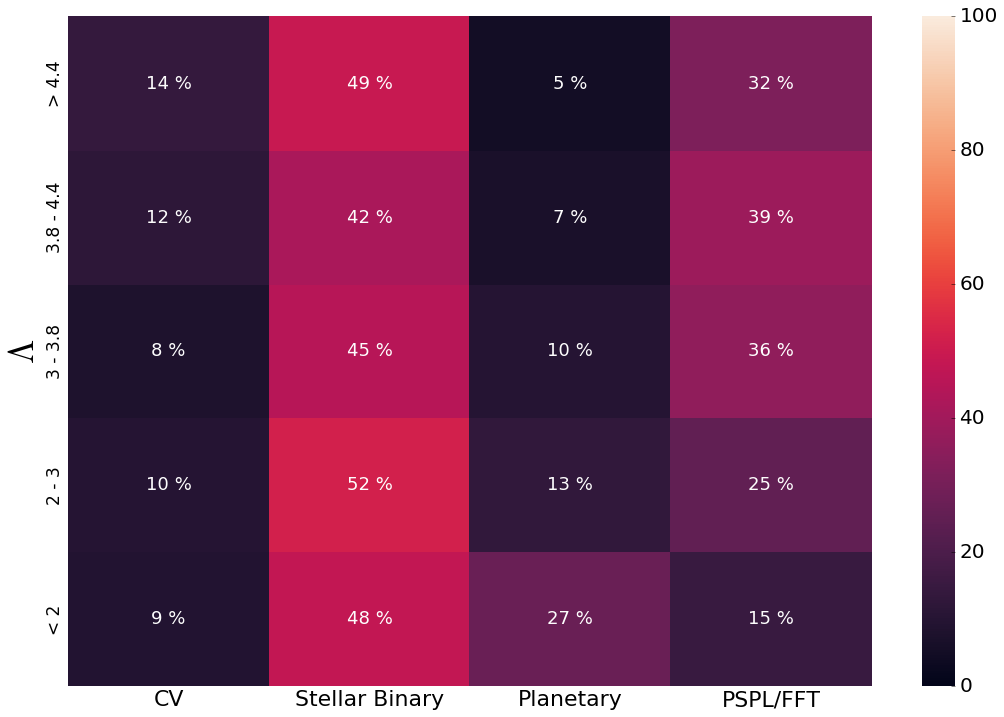

In [80]:
import seaborn as sns

#sns.set(font_scale=2)
ax = sns.heatmap(df_hm, annot=True, vmin=0, vmax=100,annot_kws={"size": 18})
ax.invert_yaxis()
ax.set_ylabel('$\Lambda$', fontsize=35)
for t in ax.texts: t.set_text(t.get_text() + " %")

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

ax.tick_params(axis='both', which='major', labelsize=22, length=0)
# ax.set_xticklabels(index, rotation = -30, fontsize = 9)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 90, fontsize = 17)
    
fig = plt.gcf()
fig.set_size_inches(18.0,12.0)

# plt.savefig('./../test_result/Chebyshev/Chebyshev_pos_log_coeff_squared_n50.png')

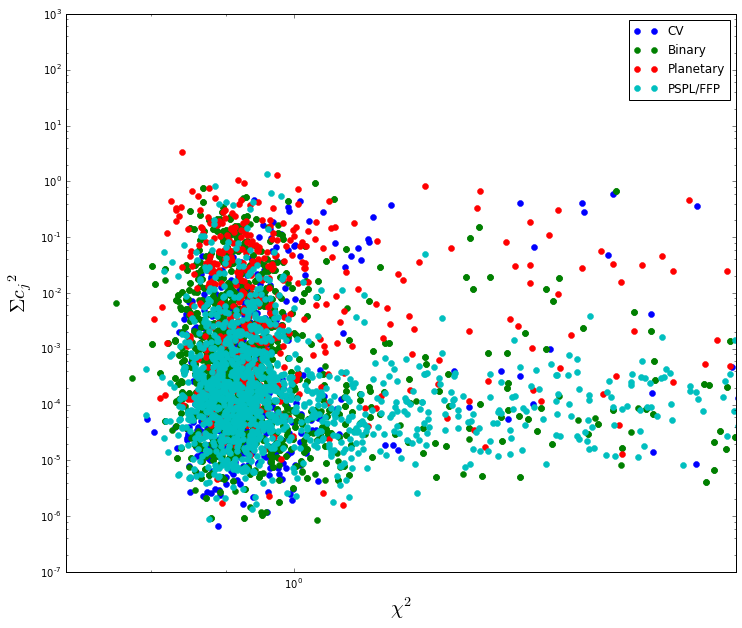

In [52]:
c_x = 0.5
c_y = 1
plt.plot(c_x*info['chi_2'][info['type']==0], c_y*(info['c_j2'][info['type']==0]-1), '.',markersize=12, label= 'CV')
plt.plot(c_x*info['chi_2'][info['type']==1], c_y*(info['c_j2'][info['type']==1]-1), '.',markersize=12, label= 'Binary')
plt.plot(c_x*info['chi_2'][info['type']==2], c_y*(info['c_j2'][info['type']==2]-1), '.',markersize=12, label= 'Planetary')
plt.plot(c_x*info['chi_2'][info['type']==3], c_y*(info['c_j2'][info['type']==3]-1), '.',markersize=12, label= 'PSPL/FFP')

plt.legend()
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1.,3)
plt.xlim(0.7,2)
plt.ylabel(r'$\Sigma {c_j}^2$', size=20)
plt.xlabel('${\chi}^2$', size=20)

fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

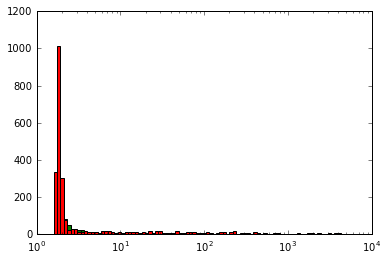

In [53]:
plt.hist(info['chi_2'][info.type==0], bins=np.logspace(0,4,100))
plt.hist(info['chi_2'][info.type==3], bins=np.logspace(0,4,100))
plt.hist(info['chi_2'][info.type==1], bins=np.logspace(0,4,100))




# plt.ylim(0,100)
plt.xscale('log')
plt.xscale('log')

In [54]:
# a0, a2, a4, a6, a8, a10 = [],[],[],[],[],[]
# a1, a3, a5, a7, a9 = [],[],[],[],[]


# for i in range(len(info.name)):
    
#     a0.append(result['c_j'][i][0])
#     a2.append(result['c_j'][i][2])
#     a4.append(result['c_j'][i][4])
#     a6.append(result['c_j'][i][6])
#     a8.append(result['c_j'][i][8])
#     a10.append(result['c_j'][i][10])
    
#     a1.append(result['c_j'][i][1])
#     a3.append(result['c_j'][i][3])
#     a5.append(result['c_j'][i][5])
#     a7.append(result['c_j'][i][7])
#     a9.append(result['c_j'][i][9])


In [59]:
len(a0)

4974

In [55]:
# info['a0']=np.asarray(a0)/np.asarray(a0)
# info['a1']=np.asarray(a1)/np.asarray(a0)
# info['a2']=np.asarray(a2)/np.asarray(a0)
# info['a3']=np.asarray(a3)/np.asarray(a0)
# info['a4']=np.asarray(a4)/np.asarray(a0)
# info['a5']=np.asarray(a5)/np.asarray(a0)
# info['a6']=np.asarray(a6)/np.asarray(a0)
# info['a7']=np.asarray(a7)/np.asarray(a0)
# info['a8']=np.asarray(a8)/np.asarray(a0)
# info['a9']=np.asarray(a9)/np.asarray(a0)
# info['a10']=np.asarray(a10)/np.asarray(a0)

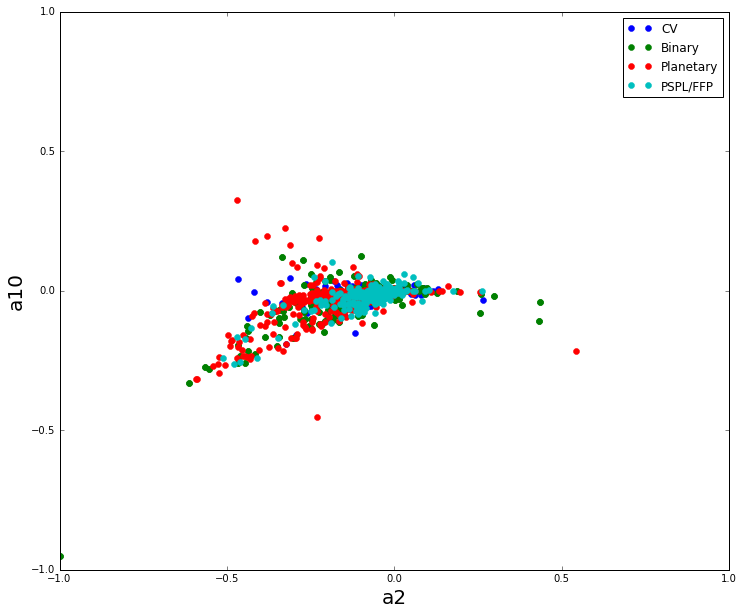

In [98]:
x = 'a2'
y = 'a10'
plt.plot(info[x][info['type']==0], info[y][info['type']==0], '.',markersize=12, label= 'CV')
plt.plot(info[x][info['type']==1], info[y][info['type']==1], '.',markersize=12, label= 'Binary')
plt.plot(info[x][info['type']==2], info[y][info['type']==2], '.',markersize=12, label= 'Planetary')
plt.plot(info[x][info['type']==3], info[y][info['type']==3], '.',markersize=12, label= 'PSPL/FFP')

plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.ylabel(y, size=20)
plt.xlabel(x, size=20)

fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

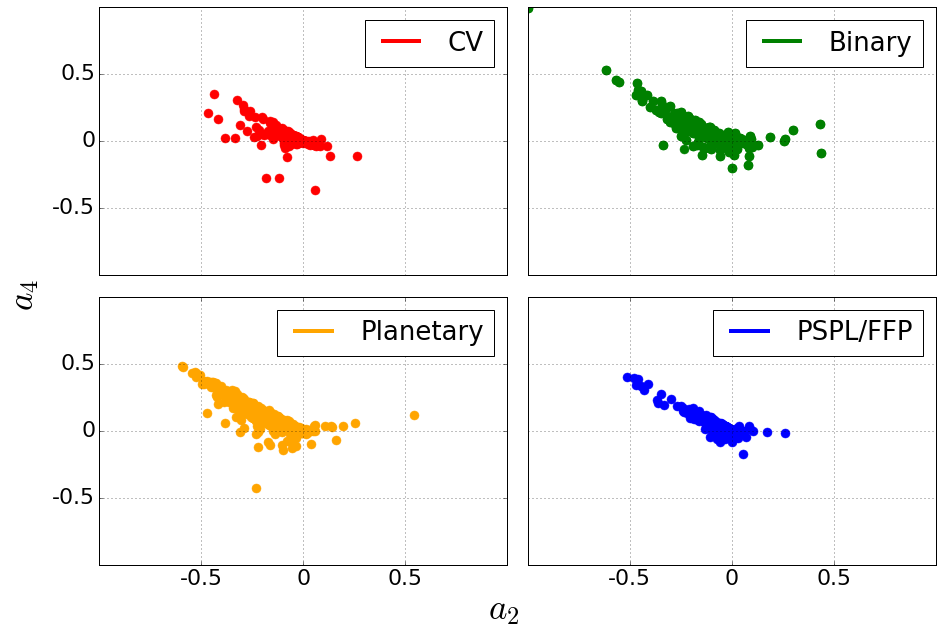

In [37]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


axs[0,0].plot(info['a2'][info['type']==0], info['a4'][info['type']==0], '.',markersize=18, label= 'CV',color='r')
axs[0,0].grid()
legend_elements = [Line2D([0], [0], color='r', lw=4, label ='CV')]
axs[0,0].legend(handles=legend_elements, prop={'size': 26})
axs[0,1].plot(info['a2'][info['type']==1], info['a4'][info['type']==1], '.',markersize=18, label= 'Binary', color='g')
axs[0,1].grid()
legend_elements = [Line2D([0], [0], color='g', lw=4, label ='Binary')]
axs[0,1].legend(handles=legend_elements, prop={'size': 26})
axs[1,0].plot(info['a2'][info['type']==2], info['a4'][info['type']==2], '.',markersize=18, label= 'Planetary',  color = 'orange')
axs[1,0].grid()
legend_elements = [Line2D([0], [0], color='orange', lw=4, label ='Planetary')]
axs[1,0].legend(handles=legend_elements, prop={'size': 26})
axs[1,1].plot(info['a2'][info['type']==3], info['a4'][info['type']==3], '.',markersize=18, label= 'PSPL/FFP', color='blue')
axs[1,1].grid()
legend_elements = [Line2D([0], [0], color='blue', lw=4, label ='PSPL/FFP')]
axs[1,1].legend(handles=legend_elements, prop={'size': 26})


axs[0, 1].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[0, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off',length=0)

axs[0, 0].tick_params(axis='y',which='both', labelsize=12)
axs[1, 0].tick_params(axis='both',which='both', labelsize=12)
axs[1, 1].tick_params(axis='x',which='both', labelsize=12)

axs[1,0].set_xticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)
axs[1,1].set_xticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)

axs[0,0].set_yticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)
axs[1,0].set_yticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)

# axs[1,0].set_xticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)
# axs[1,1].set_xticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)

# axs[0,0].set_yticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)
# axs[1,0].set_yticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)


axs[0, 0].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[1, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off', length=0)

axs[0,0].set_ylim((-1,1))
axs[0,0].set_xlim((-1,1))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.05, hspace=0.08) 

fig.text(0.5, 0.05, '$a_2$', ha='center',size=35)
fig.text(0.04, 0.5, '$a_4$', va='center', rotation='vertical',size=35)

fig = plt.gcf()
fig.set_size_inches(15.0,10.0)
fig.savefig('./../test_result/Chebyshev/a4_a2_dt10_n50.png')

In [66]:
info[info['type']==1][(info['a2'][info['type']==1]>-1) & (info['a2'][info['type']==1]<-0.5)]

,c_j2,chi_2,type,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10
2863,25.500000,6.234587e+55,1,1.0,0.218143,-0.904827,-0.612907,0.637424,0.891007,-0.248690,-0.999507,-0.187381,0.917755,0.587785
3077,2.423077,2.329057e+48,1,1.0,-0.030550,-0.891279,0.072375,0.607707,-0.068539,-0.257038,0.021461,-0.037549,0.039157,0.191531
4886,25.500000,6.234587e+55,1,1.0,0.218143,-0.904827,-0.612907,0.637424,0.891007,-0.248690,-0.999507,-0.187381,0.917755,0.587785
4898,2.423077,2.329057e+48,1,1.0,-0.030550,-0.891279,0.072375,0.607707,-0.068539,-0.257038,0.021461,-0.037549,0.039157,0.191531


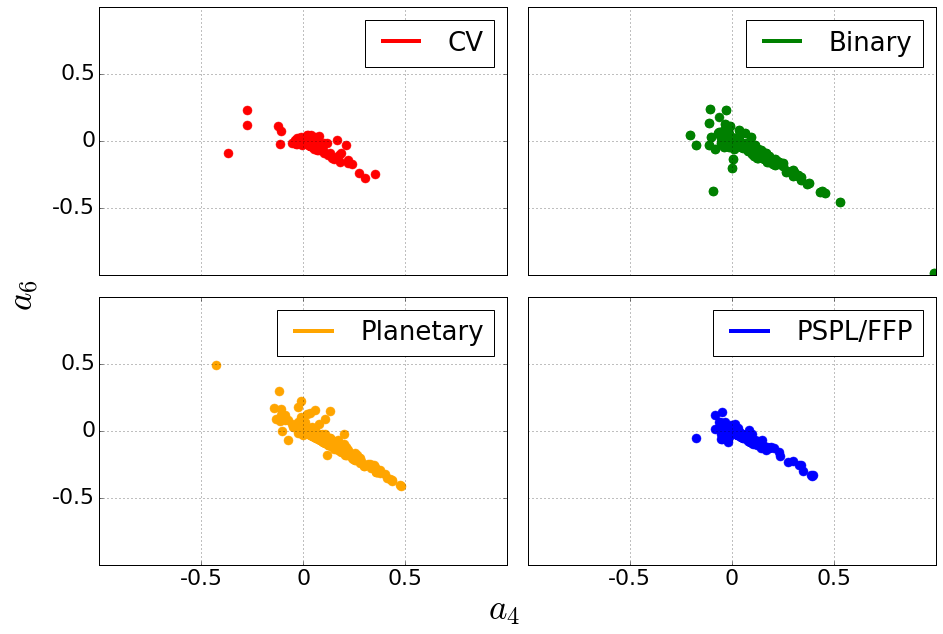

In [36]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


axs[0,0].plot(info['a4'][info['type']==0], info['a6'][info['type']==0], '.',markersize=18, label= 'CV',color='r')
axs[0,0].grid()
legend_elements = [Line2D([0], [0], color='r', lw=4, label ='CV')]
axs[0,0].legend(handles=legend_elements, prop={'size': 26})
axs[0,1].plot(info['a4'][info['type']==1], info['a6'][info['type']==1], '.',markersize=18, label= 'Binary', color='g')
axs[0,1].grid()
legend_elements = [Line2D([0], [0], color='g', lw=4, label ='Binary')]
axs[0,1].legend(handles=legend_elements, prop={'size': 26})
axs[1,0].plot(info['a4'][info['type']==2], info['a6'][info['type']==2], '.',markersize=18, label= 'Planetary',  color = 'orange')
axs[1,0].grid()
legend_elements = [Line2D([0], [0], color='orange', lw=4, label ='Planetary')]
axs[1,0].legend(handles=legend_elements, prop={'size': 26})
axs[1,1].plot(info['a4'][info['type']==3], info['a6'][info['type']==3], '.',markersize=18, label= 'PSPL/FFP', color='blue')
axs[1,1].grid()
legend_elements = [Line2D([0], [0], color='blue', lw=4, label ='PSPL/FFP')]
axs[1,1].legend(handles=legend_elements, prop={'size': 26})

axs[0, 1].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[0, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off',length=0)

axs[0, 0].tick_params(axis='y',which='both', labelsize=12)
axs[1, 0].tick_params(axis='both',which='both', labelsize=12)
axs[1, 1].tick_params(axis='x',which='both', labelsize=12)

axs[1,0].set_xticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)
axs[1,1].set_xticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)

axs[0,0].set_yticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)
axs[1,0].set_yticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)

# axs[1,0].set_xticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)
# axs[1,1].set_xticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)

# axs[0,0].set_yticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)
# axs[1,0].set_yticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)


axs[0, 0].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[1, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off', length=0)

axs[0,0].set_ylim((-1,1))
axs[0,0].set_xlim((-1,1))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.05, hspace=0.08) 

fig.text(0.5, 0.05, '$a_4$', ha='center',size=35)
fig.text(0.04, 0.5, '$a_6$', va='center', rotation='vertical',size=35)

fig = plt.gcf()
fig.set_size_inches(15.0,10.0)
fig.savefig('./../test_result/Chebyshev/a6_a4_dt10_n50.png')

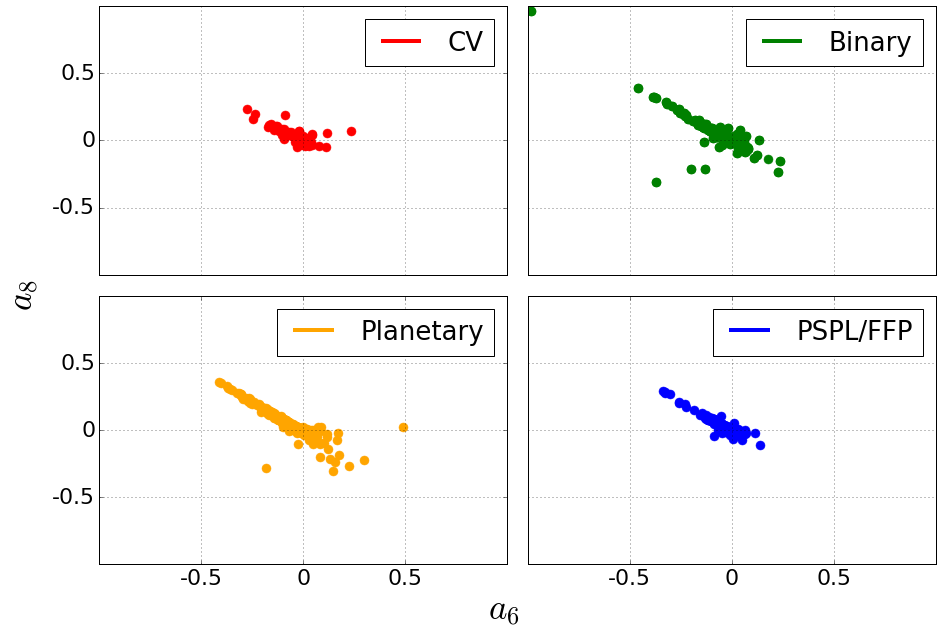

In [35]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


axs[0,0].plot(info['a6'][info['type']==0], info['a8'][info['type']==0], '.',markersize=18, label= 'CV',color='r')
axs[0,0].grid()
legend_elements = [Line2D([0], [0], color='r', lw=4, label ='CV')]
axs[0,0].legend(handles=legend_elements, prop={'size': 26})
axs[0,1].plot(info['a6'][info['type']==1], info['a8'][info['type']==1], '.',markersize=18, label= 'Binary', color='g')
axs[0,1].grid()
legend_elements = [Line2D([0], [0], color='g', lw=4, label ='Binary')]
axs[0,1].legend(handles=legend_elements, prop={'size': 26})
axs[1,0].plot(info['a6'][info['type']==2], info['a8'][info['type']==2], '.',markersize=18, label= 'Planetary',  color = 'orange')
axs[1,0].grid()
legend_elements = [Line2D([0], [0], color='orange', lw=4, label ='Planetary')]
axs[1,0].legend(handles=legend_elements, prop={'size': 26})
axs[1,1].plot(info['a6'][info['type']==3], info['a8'][info['type']==3], '.',markersize=18, label= 'PSPL/FFP', color='blue')
axs[1,1].grid()
legend_elements = [Line2D([0], [0], color='blue', lw=4, label ='PSPL/FFP')]
axs[1,1].legend(handles=legend_elements, prop={'size': 26})

axs[0, 1].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[0, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off',length=0)

axs[0, 0].tick_params(axis='y',which='both', labelsize=12)
axs[1, 0].tick_params(axis='both',which='both', labelsize=12)
axs[1, 1].tick_params(axis='x',which='both', labelsize=12)

axs[1,0].set_xticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)
axs[1,1].set_xticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)

axs[0,0].set_yticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)
axs[1,0].set_yticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)

# axs[1,0].set_xticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)
# axs[1,1].set_xticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)

# axs[0,0].set_yticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)
# axs[1,0].set_yticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)



axs[0, 0].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[1, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off', length=0)

axs[0,0].set_ylim((-1,1))
axs[0,0].set_xlim((-1,1))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.05, hspace=0.08) 

fig.text(0.5, 0.05, '$a_6$', ha='center',size=35)
fig.text(0.04, 0.5, '$a_8$', va='center', rotation='vertical',size=35)

fig = plt.gcf()
fig.set_size_inches(15.0,10.0)
fig.savefig('./../test_result/Chebyshev/a8_a6_dt10_n50.png')

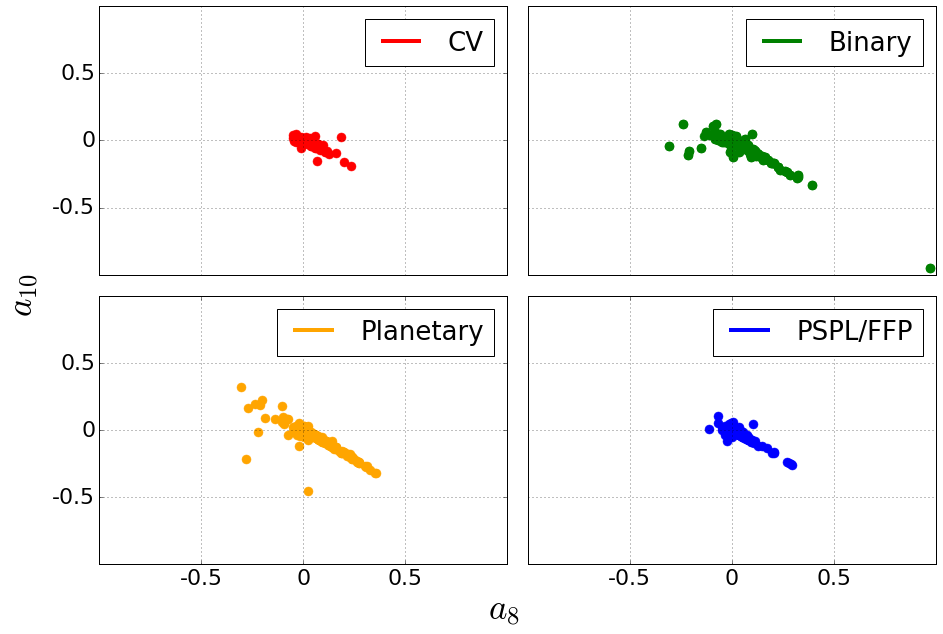

In [34]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


axs[0,0].plot(info['a8'][info['type']==0], info['a10'][info['type']==0], '.',markersize=18, label= 'CV',color='r')
axs[0,0].grid()
legend_elements = [Line2D([0], [0], color='r', lw=4, label ='CV')]
axs[0,0].legend(handles=legend_elements, prop={'size': 26})
axs[0,1].plot(info['a8'][info['type']==1], info['a10'][info['type']==1], '.',markersize=18, label= 'Binary', color='g')
axs[0,1].grid()
legend_elements = [Line2D([0], [0], color='g', lw=4, label ='Binary')]
axs[0,1].legend(handles=legend_elements, prop={'size': 26})
axs[1,0].plot(info['a8'][info['type']==2], info['a10'][info['type']==2], '.',markersize=18, label= 'Planetary',  color = 'orange')
axs[1,0].grid()
legend_elements = [Line2D([0], [0], color='orange', lw=4, label ='Planetary')]
axs[1,0].legend(handles=legend_elements, prop={'size': 26})
axs[1,1].plot(info['a8'][info['type']==3], info['a10'][info['type']==3], '.',markersize=18, label= 'PSPL/FFP', color='blue')
axs[1,1].grid()
legend_elements = [Line2D([0], [0], color='blue', lw=4, label ='PSPL/FFP')]
axs[1,1].legend(handles=legend_elements, prop={'size': 26})

axs[0, 1].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[0, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off',length=0)

axs[0, 0].tick_params(axis='y',which='both', labelsize=12)
axs[1, 0].tick_params(axis='both',which='both', labelsize=12)
axs[1, 1].tick_params(axis='x',which='both', labelsize=12)

axs[1,0].set_xticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)
axs[1,1].set_xticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)

axs[0,0].set_yticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)
axs[1,0].set_yticklabels(['',-0.5,0,0.5], rotation = 0, fontsize = 22)

# axs[1,0].set_xticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)
# axs[1,1].set_xticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)

# axs[0,0].set_yticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)
# axs[1,0].set_yticklabels(['',-0.4,-0.2,0,0.2,0.4], rotation = 0, fontsize = 22)


axs[0, 0].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
axs[1, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off', length=0)

axs[0,0].set_ylim((-1,1))
axs[0,0].set_xlim((-1,1))

# axs[0,0].set_yscale('log')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.05, hspace=0.08) 

fig.text(0.5, 0.05, '$a_8$', ha='center',size=35)
fig.text(0.04, 0.5, '$a_{10}$', va='center', rotation='vertical',size=35)

fig = plt.gcf()
fig.set_size_inches(15.0,10.0)
fig.savefig('./../test_result/Chebyshev/a10_a8_dt10_n50.png')